## KKN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log
from random import shuffle
import math
from random import shuffle

In [2]:
class DataPoint:
    def __str__(self):
        return "< " + str(self.label) + ": " + str(self.features) + " >"
    def __init__(self, label, features):
        self.label = label # the classification label of this data point
        self.features = features

In [3]:
def get_data(filename):
    data = []
    with open(filename) as file:
        for line in file:
            record = np.fromstring(line, sep=",")
            label = record[-1]
            record = record[:-1]
            data.append(DataPoint(label, record))
    return data

In [4]:
# Continues Features idx = [2-17] including 17
def createBins(data):
    bins = {}
    for featureIdx in range(2, 18): #Change to (2, 18)
        #find min and max
        minF = float('inf')
        maxF = float('-inf')
        for d in data:
            feature = d.features[featureIdx]
            if feature < minF:
                minF = feature
            elif feature > maxF:
                maxF = feature
    
        #create bins and add to bins dictionary
        divs = (maxF - minF)/3.0
        bins[featureIdx] = [minF+divs,maxF - divs]
        
        # Replace all continues variables with the bin that it is in
        for i in range(len(data)):
            oldFeature = data[i].features[featureIdx]
            if oldFeature < bins[featureIdx][0]:
                newFeature = 0
            elif oldFeature < bins[featureIdx][1]:
                newFeature = 1
            else:
                newFeature = 2
            data[i].features[featureIdx] = newFeature
    return data, bins

def find_bin(featureIdx, bins, num):
    boundaries = bins[featureIdx]
    if num < boundaries[0]:
        return 0
    elif num < boundaries[1]:
        return 1
    else:
        return 2


def bayesClassify(data, data_point):
    totalProbA = 1 #1
    totalProbB = 1 #0
    for featureIdx in range(len(data_point.features)):
        numA = 0
        numB = 0
        denA = 0
        denB = 0
        for d in data:
            if d.label == 1:
                denA += 1
                if d.features[featureIdx] == data_point.features[featureIdx]:
                    numA += 1
            if d.label == 0:
                denB += 1
                if d.features[featureIdx] == data_point.features[featureIdx]:
                    numB += 1
        # Laplace Smoothing
        if numA == 0 or numB == 0:
            numA += 1
            numB += 1
            denA += 1
            denB += 1
        #print(str(numA/denB))
        #print(str(numB/denB) + "\n")
        totalProbA *= (numA/denA)
        totalProbB *= (numB/denB)
    if totalProbA >= totalProbB:
        return 1
    return 0
                    
# find probabilities one column at a time not Yes then No, but together at the same time.
# this will help with laplace smoothing
def bin_dataPoint(data_point, bins):
    for featureIdx in range(2, 5): # CHANGE TO (2, 18)
        b = find_bin(featureIdx, bins, data_point.features[featureIdx])
        data_point.features[featureIdx] = b
    return data_point
   
def make_prediction(data, data_point, bins):
    # Probability of yes (1)
    #d, bins = createBins(data)
    #dp = bin_dataPoint(data_point, bins)
    return bayesClassify(data, data_point) 

def x_fold(data, fold):
    return [data[i::fold] for i in range(fold)]

def cross_validation():
    average = 0
    d = get_data("messidor_features.txt")
    shuffle(d)
    data, bins = createBins(d)
    fold = x_fold(data, 5)
    average = 0
    totalTN = 0
    totalFP = 0
    totalFN = 0
    totalTP = 0
    for i in range(5):
        test_set = fold[i]
        train_set = []
        for j in range(5):
            if j == i:
                continue
            train_set += fold[j]
        
        
    
        #Calc Confusion Matrix
        tn = 0
        fp = 0
        fn = 0
        tp = 0
        for d in test_set:
            classification = make_prediction(train_set, d, bins)
            #print(classification)
            if classification == 0:
                if d.label == 0:
                    tn += 1
                    totalTN += 1
                else:
                    fn += 1
                    totalFN += 1
            else:
                if d.label == 0:
                    fp += 1
                    totalFP += 1
                else:
                    tp += 1
                    totalTP += 1
        average += (tp+tn) / (tn+fp+fn+tp)

    #Print Confusion Matrix
    cfMat = np.array([[totalTN, totalFP], [totalFN, totalTP]])
    columnHeader = ["Predicted: Non_Diabetic", "Predicted: Diabetic"]
    rowHeader = ["Actual: Non_Diabetic", "Actual: Diabetic"]
    print(pd.DataFrame(cfMat, rowHeader, columnHeader))
    print("\nAverage Accuracy: " + str(average/5 * 100)) 
    print("Average Precision: " + str(totalTP/(totalTP+totalFP)*100))
    print("Average Recall: " + str(totalTP/(totalTP+totalFN)*100))
    

cross_validation()  

#dat = get_data("test.txt")
#d, bins = createBins(dat)
#print(bins)
#print(d[1])
#print(bin_dataPoint(d[1], bins))
#print(bayesClassify(d, d[1]))
#make_prediction(dat, dat[0])
#d, bins = createBins(dat)
#print(bins)
#pr = pContin(d, bins, dat[0], 1)
#print(pr)



                      Predicted: Non_Diabetic  Predicted: Diabetic
Actual: Non_Diabetic                      371                  169
Actual: Diabetic                          306                  305

Average Accuracy: 58.72576698663655
Average Precision: 64.34599156118144
Average Recall: 49.91816693944354


In [5]:
def normalize(data):
    for featureIdx in range(len(data[0].features)):
        #find min and max
        minF = float('inf')
        maxF = float('-inf')
        for d in data:
            feature = d.features[featureIdx]
            if feature < minF:
                minF = feature
            elif feature > maxF:
                maxF = feature
        for i in range(len(data)):
            data[i].features[featureIdx] = (data[i].features[featureIdx] - minF) / (maxF - minF)
    return data

In [6]:
def kknClassifier(data, data_point):
    # for d in data, calculate distance from d to dp by using sqrt( sum(d.feature-dp.feature)^2)
    # put distance in minDist list if dis < max(minDistList): minDist.remove(max(minDist)), minDist.append(dis)
    minList = {}
    for d in data:
        dist = 0
        for f in range(len(data_point.features)):
            dist += math.pow(data_point.features[f]-d.features[f], 2)
        dist = math.sqrt(dist)
        minList[dist] = d.label
        # Need to store the object
    
    # Create List with idx = k, value = classification
    keys = sorted(list(minList.keys()))
    vote = 0
    classificationsk = [0]
    for i in range(10):
        if minList[keys[i]] == 0:
            vote -= 1
        else:
            vote += 1
        if vote < 0:
            classificationsk.append(0)
        else:
            classificationsk.append(1)
    return classificationsk




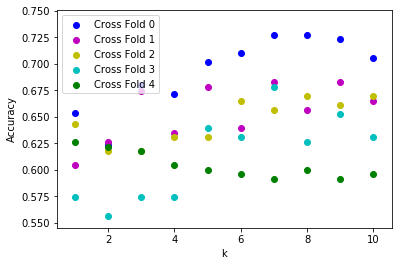

7

In [7]:
# for d in data, calculate distance from d to dp by using sqrt( sum(d.feature-dp.feature)^2)
# put distance in minDist list if dis < max(minDistList): minDist.remove(max(minDist)), minDist.append(dis)
def x_fold(data, fold):
    return [data[i::fold] for i in range(fold)]

def find_best_k(d, outputGraph):
    average = 0
    fold = x_fold(d, 5)
    
    average_Accuracies = [0 for i in range(11)]
    all_accuracies = []
    color=['b','m','y', 'c', 'g']
    for i in range(5):
        test_set = fold[i]
        train_set = []
        for j in range(5):
            if j == i:
                continue
            train_set += fold[j]
        # for each cross fold, go through the test set and get classificationList(all K's)
        accuracies = [0 for i in range(11)]
        for dp in test_set:
            classifications = kknClassifier(train_set, dp)
            # Need to keep track of accuracy for each k, can use a list
            for k in range(1, len(classifications)):
                if classifications[k] == dp.label:
                    accuracies[k] += 1
        # calculate accuracies by dividing each index by len(test_set)
        accuracies = [x/len(test_set) for x in accuracies]
        for a in range(len(accuracies)):
            average_Accuracies[a] += accuracies[a]
        # need to create a graph of k vs accuracy for each fold
        #all_accuracies.append(accuracies[1:])
        
        plt.scatter([x for x in range(1,11)], accuracies[1:], color=color[i], label="Cross Fold " +str(i))
    
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.legend(loc='upper left')
    plt.show()
    average_Accuracies = [x/5 for x in average_Accuracies]
    return average_Accuracies.index(max(average_Accuracies))


find_best_k(get_data("messidor_features.txt"), True)


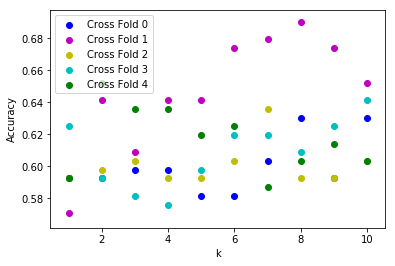

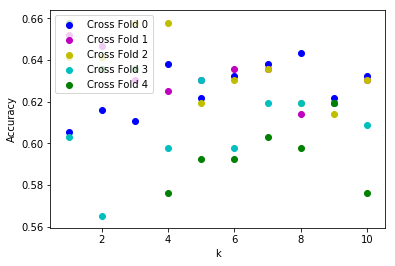

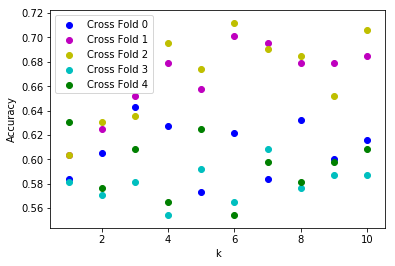

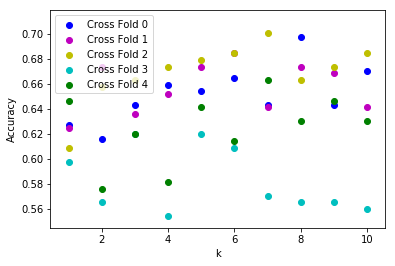

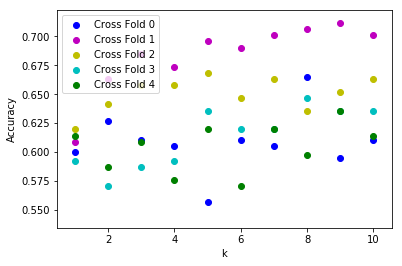

                      Predicted: Non_Diabetic  Predicted: Diabetic
Actual: Non_Diabetic                      308                  232
Actual: Diabetic                          213                  398

Average Accuracy: 61.33796698523023
Average Precision: 63.17460317460317
Average Recall: 65.13911620294598


In [8]:
def findAccuracy():
    d = normalize(get_data("messidor_features.txt"))
    
    fold = x_fold(d, 5)
    average_Accuracies = [0 for i in range(11)]
    totalTN = 0
    totalFP = 0
    totalFN = 0
    totalTP = 0
    for i in range(5):
        test_set = fold[i]
        train_set = []
        for j in range(5):
            if j == i:
                continue
            train_set += fold[j]
    # for each cross fold, go through the test set and get classificationList(all K's)
        accuracies = [0 for i in range(11)]
        k = find_best_k(train_set, False)
        for d in test_set:
            classifications = kknClassifier(train_set, d)
            classification = classifications[k]
            if classification == 0:
                if d.label == 0:
                    #tn += 1
                    totalTN += 1
                else:
                    #fn += 1
                    totalFN += 1
            else:
                if d.label == 0:
                    #fp += 1
                    totalFP += 1
                else:
                    #tp += 1
                    totalTP += 1
    
    cfMat = np.array([[totalTN, totalFP], [totalFN, totalTP]])
    columnHeader = ["Predicted: Non_Diabetic", "Predicted: Diabetic"]
    rowHeader = ["Actual: Non_Diabetic", "Actual: Diabetic"]
    print(pd.DataFrame(cfMat, rowHeader, columnHeader))
    print("\nAverage Accuracy: " + str((totalTP+totalTN)/(totalTP+totalTN+totalFP+totalFN) * 100)) 
    print("Average Precision: " + str(totalTP/(totalTP+totalFP)*100))
    print("Average Recall: " + str(totalTP/(totalTP+totalFN)*100))    
    
findAccuracy()

